In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

sns.set_style('white', {'legend.frameon':True})
mpl.rcParams['figure.figsize'] = 25, 10

In [3]:
trenovacie = pd.read_csv("data/predspracovane_train.csv")


In [4]:
trenovacie['class'].unique()

array(['negative', 'increased binding protein',
       'decreased binding protein'], dtype=object)

In [5]:
overovacie = pd.read_csv("data/predspracovane_valid.csv")
testovacie = pd.read_csv("data/predspracovane_test.csv")


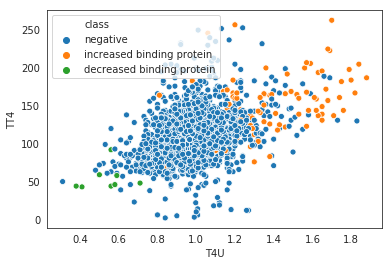

In [6]:
sns.scatterplot('T4U', 'TT4', data=trenovacie[['T4U', 'TT4', 'class']], hue='class')

Pre manualne pravidla rozhodovania sme zvolili atributy T4U a TT4. Podla scatterplotu vidno, ze maju vplyv na class. Increased binding protein bude ked je T4U viac ako 1.2 alebo TT4 viac ako 172. Decreased ak je T4U menej ako 0.7 alebo TT4 menej ako 50. V ostatnych pripadoch je negative.

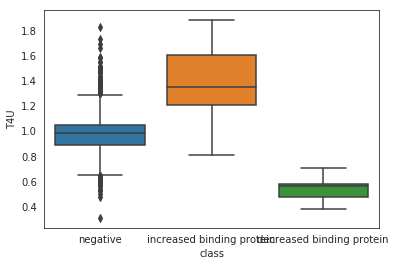

In [7]:
sns.boxplot('class', 'T4U', data=trenovacie)

Na pravidlo podla jedneho atributu sme zvolil T4U, lebo sa zda mat najmenej prekryvajucich sa hodnot. Hranica medzi Increased binding protein a negative je T4U=1,1, medzi Decreased binding protein a negative je T4U=0.7

In [8]:
porovnanie_vysledkov = pd.DataFrame({'Sposob': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1 macro': []})

In [9]:
def podla_testyriu(data):
    vysledok = []
    for zaznam in data['T4U']:
        if zaznam < 0.7:
            vysledok.append('decreased binding protein')
        elif zaznam > 1.1:
            vysledok.append('increased binding protein')
        else:
            vysledok.append('negative')
            
    return vysledok


manualna_jeden = podla_testyriu(overovacie)
# VYPIS METRIK PRE MANUALNE PRAVIDLA S JEDNYM ATRIBUTOM
a = accuracy_score(overovacie['class'], manualna_jeden)
p = precision_score(overovacie['class'], manualna_jeden, average='macro')
r = recall_score(overovacie['class'], manualna_jeden, average='macro')
f = f1_score(overovacie['class'], manualna_jeden, average='macro')
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
print('Efjednicka\t: ' + str(f))
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Manualne pravidlo T4U', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)


Accuracy 	: 0.8065843621399177
Precision	: 0.428111620087498
Recall 	: 0.907515923566879
Efjednicka	: 0.46278112954583545


In [10]:
def podla_testyriuaajtetestyritamdajmenechjesranda(data):
    vysledok = []
    for testyriu, tetestyri in data[['T4U', 'TT4']].values:
        # 172, 1.2
        # print(zaznam)
        if testyriu > 1.2 or tetestyri > 172:
            vysledok.append('increased binding protein')
        elif testyriu < 0.7 or tetestyri < 50:
            vysledok.append('decreased binding protein')
        else:
            vysledok.append('negative')
            
    return vysledok


manualna_dva = podla_testyriuaajtetestyritamdajmenechjesranda(overovacie)
# VYPIS METRIK PRE MANUALNE PRAVIDLA S DVOMA ATRIBUTMI
a = accuracy_score(overovacie['class'], manualna_dva)
p = precision_score(overovacie['class'], manualna_dva, average='macro')
r = recall_score(overovacie['class'], manualna_dva, average='macro')
f = f1_score(overovacie['class'], manualna_dva, average='macro')
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
print('Efjednicka\t: ' + str(f))
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Manualne pravidlo T4U+TT4', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)

Accuracy 	: 0.8621399176954733
Precision	: 0.43110705233427565
Recall 	: 0.9006652512384997
Efjednicka	: 0.4747719374812025


In [11]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import *

stlpce_na_zakodovanie = ['FTI measured', 'education', 'lithium', 'on thyroxine', 'tumor', 'relationship',
                         'thyroid surgery', 'workclass', 'I131 treatment', 'marital-status', 'goitre',
                         'native-country', 'hypopituitary', 'query on thyroxine', 'T3 measured', 'referral source',
                         'occupation', 'TBG measured', 'race', 'pregnant', 'TSH measured', 'query hyperthyroid',
                         'TT4 measured', 'on antithyroid medication', 'sick', 'T4U measured', 'psych',
                         'query hypothyroid', 'sex']
kodovace = {}
for stlpec in stlpce_na_zakodovanie:
    kodovace[stlpec] = LabelEncoder()
    kodovace[stlpec].fit(trenovacie[stlpec].append(overovacie[stlpec]).append(testovacie[stlpec]))


def transformuj(co):
    vystup = co.copy()
    for ss in stlpce_na_zakodovanie:
        try:
            vystup[ss] = kodovace[ss].transform(vystup[ss])
        except ValueError:
            print("KURVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA" + ss)
    return vystup


skorozakodovane = transformuj(trenovacie).drop(['class', 'date_of_birth', 'name', 'address'], axis=1)
trafo = make_column_transformer(
    (list(set(list(skorozakodovane.columns)) - set(stlpce_na_zakodovanie)), "passthrough"),
    (stlpce_na_zakodovanie, OneHotEncoder(categories='auto', handle_unknown='ignore')))
trafo.fit(skorozakodovane)


def zakoduj(vstup):
    # return pd.get_dummies(data, columns=stlpce_na_zakodovanie)  # ONE HOT ENCODING
    data = pd.DataFrame(vstup)
    vystup = pd.DataFrame(trafo.transform(transformuj(data).drop(['class', 'date_of_birth', 'name', 'address'], axis=1)).toarray())
    # vystup = pd.DataFrame(trafo.transform(vstup).toarray())
    vystup['class'] = vstup['class']
    return vystup

# print(trenovacie['education'].unique())
# tranformovane = transformuj(trenovacie)
zakodovane_trenovacie = zakoduj(trenovacie)
# print(trenovacie['education'].unique())

In [12]:
def natrenuj(klasifikator, data, podla_stlpcov=[]):
    X = data[podla_stlpcov] if podla_stlpcov else data.select_dtypes(numpy.number) 
    # v zakodovanych datach su (temer) vsetky atributy numericke takze ked vezmeme vsetky numericke tak je dobre
    y = data['class']
    klasifikator.fit(X, y)


klasifikator_vsetkeho = DecisionTreeClassifier(criterion='entropy')
natrenuj(klasifikator_vsetkeho, zakodovane_trenovacie)
dolezitost = pd.DataFrame({'Feature': zakodovane_trenovacie.select_dtypes(numpy.number).columns, 'Importance': klasifikator_vsetkeho.feature_importances_})
dolezitost.sort_values(by='Importance', ascending=False).head(15)

,Feature,Importance
2,2,0.456510
1,1,0.219727
6,6,0.071075
9,9,0.041608
0,0,0.030046
3,3,0.023623
109,109,0.020701
4,4,0.018906
39,39,0.015093
5,5,0.014972


Pri trenovani stromu so vsetkymi atributmi (okrem adresy, mena a datumu narodenia) s one-hot encodovanymi kategorickymi atributmi sa ako najdolezitejsie atributy ukazali T4U, T3, TT4 a TSH

In [13]:
pd.Series(cross_val_score(klasifikator_vsetkeho, zakodovane_trenovacie.select_dtypes(numpy.number), zakodovane_trenovacie['class'], cv=10)).mean()

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.9669765311127959

In [14]:
def testy_hlbok(trenovacie, overovacie, stlpce=[], klasifikator=DecisionTreeClassifier(criterion='entropy')):
    X_train = trenovacie[stlpce] if stlpce else trenovacie.select_dtypes(numpy.number)
    y_train = trenovacie['class']
    results = []
    X_test = overovacie[stlpce] if stlpce else overovacie.select_dtypes(numpy.number)
    y_test = overovacie['class']
    # print(len(X_train.columns))
    # print(len(X_test.columns))
    for i in X_train.columns: 
        if i not in X_test.columns:
            print(i)
    estimators = []
    for i in range(1, 20):
        row = {'model_complexity': i}
        
        clf = klasifikator
        clf.max_depth = i
    
        pred = clf.fit(X_train, y_train).predict(X_train)
        row['train_accuracy'] = accuracy_score(y_train, pred)
        row['train_f1'] = f1_score(y_train, pred, average='macro')
    
        pred = clf.predict(X_test)
        row['valid_accuracy'] = accuracy_score(y_test, pred)
        row['valid_f1'] = f1_score(y_test, pred, average='macro') 
        results.append(row)
        estimators.append(clf)
        
    return results

In [15]:
def pridajnuly(z, do):
    for stlpec in z.columns:
        if stlpec not in do.columns:
            do[stlpec] = 0

In [16]:
zakodovane_overovacie = zakoduj(overovacie)
# pridajnuly(zakodovane_trenovacie, zakodovane_overovacie)
zlozitosti_na_vsetkom = pd.DataFrame(testy_hlbok(zakodovane_trenovacie, zakodovane_overovacie, klasifikator=klasifikator_vsetkeho))
zlozitosti_na_vsetkom

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-s

,model_complexity,train_accuracy,train_f1,valid_accuracy,valid_f1
0,1,0.954566,0.325585,0.969136,0.328109
1,2,0.969252,0.534461,0.969136,0.504132
2,3,0.969252,0.547640,0.959877,0.476945
3,4,0.977972,0.831476,0.973251,0.709294
4,5,0.988527,0.949269,0.975309,0.677590
5,6,0.994493,0.976567,0.971193,0.687810
6,7,0.997705,0.990492,0.971193,0.726837
7,8,1.000000,1.000000,0.972222,0.698777
8,9,1.000000,1.000000,0.970165,0.691470
9,10,1.000000,1.000000,0.973251,0.709294


Toto tu zavana pretrenovanim...

In [17]:
pocet_neg = trenovacie[trenovacie['class'] == 'negative'].count()
pocet_inc = trenovacie[trenovacie['class'] == 'increased binding protein'].count()
pocet_dec = trenovacie[trenovacie['class'] == 'decreased binding protein'].count()

klasifikator_vahy = DecisionTreeClassifier(criterion='entropy', class_weight='balanced') # klasifikator vyvazuje pocty tried
natrenuj(klasifikator_vahy, zakodovane_trenovacie)
pd.Series(cross_val_score(klasifikator_vahy, zakodovane_trenovacie.select_dtypes(numpy.number), zakodovane_trenovacie['class'], cv=10)).mean()

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.9678876206151846

In [18]:

zlozitosti_na_vsetkom = pd.DataFrame(testy_hlbok(zakodovane_trenovacie, zakodovane_overovacie, klasifikator=klasifikator_vahy))
zlozitosti_na_vsetkom


/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,model_complexity,train_accuracy,train_f1,valid_accuracy,valid_f1
0,1,0.045434,0.107041,0.030864,0.085516
1,2,0.876090,0.556476,0.825103,0.452224
2,3,0.849013,0.544571,0.800412,0.444397
3,4,0.912804,0.813796,0.884774,0.554578
4,5,0.929325,0.834408,0.895062,0.566720
5,6,0.945388,0.858401,0.901235,0.553895
6,7,0.988068,0.955422,0.954733,0.632280
7,8,0.988527,0.957727,0.949588,0.620236
8,9,0.995411,0.981836,0.957819,0.631048
9,10,0.996329,0.985323,0.960905,0.639773


In [19]:
cls = DecisionTreeClassifier(criterion='entropy', max_depth=5)
X = trenovacie[['TT4', 'T4U', 'T3']]
y = trenovacie['class']
cls.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
pred = cls.predict(overovacie[['TT4', 'T4U', 'T3']])

In [21]:

accuracy_score(overovacie['class'], pred)
f1_score(overovacie['class'], pred, average='macro')


0.7054295458236345

In [22]:
complexity_df = pd.DataFrame(testy_hlbok(trenovacie, overovacie, ['TT4', 'T4U', 'T3']))
complexity_df.head(10)

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-s

,model_complexity,train_accuracy,train_f1,valid_accuracy,valid_f1
0,1,0.954566,0.325585,0.969136,0.328109
1,2,0.969252,0.534461,0.969136,0.504132
2,3,0.969252,0.534461,0.969136,0.504132
3,4,0.973382,0.792936,0.974280,0.699469
4,5,0.980725,0.857722,0.973251,0.727831
5,6,0.984855,0.935905,0.967078,0.776108
6,7,0.988527,0.947500,0.971193,0.773602
7,8,0.991739,0.965591,0.968107,0.774371
8,9,0.994952,0.978168,0.970165,0.749179
9,10,0.996329,0.984378,0.970165,0.780631


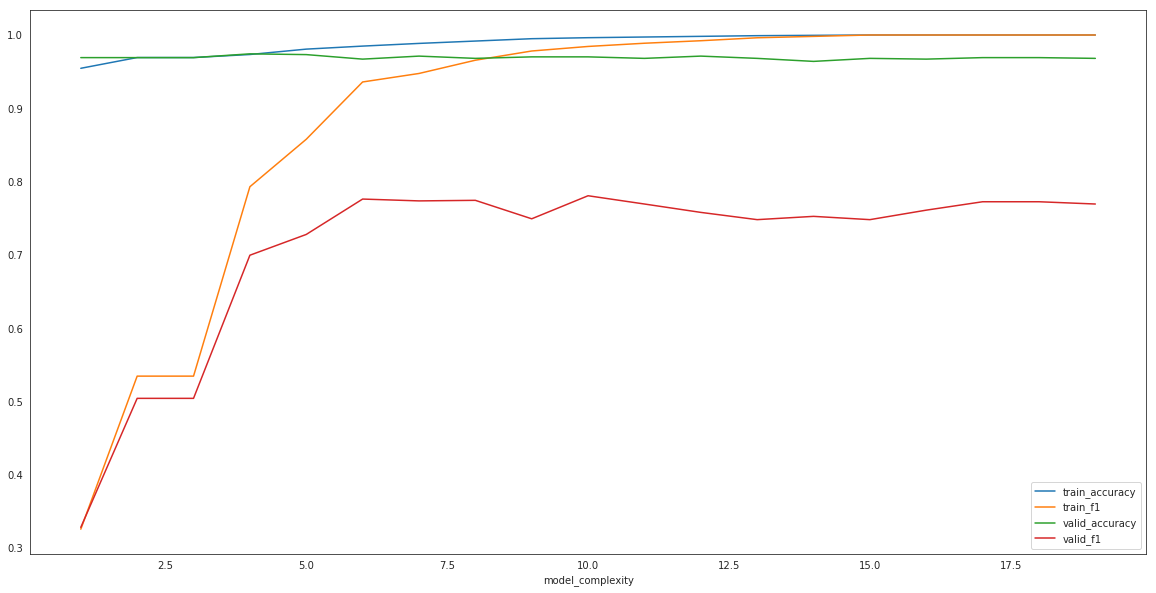

In [23]:
complexity_df.plot(x='model_complexity', figsize=(20, 10))

In [24]:
porovnanie_vysledkov

,Sposob,accuracy,precision,recall,f1 macro
0,Manualne pravidlo T4U,0.806584,0.428112,0.907516,0.462781
1,Manualne pravidlo T4U+TT4,0.862140,0.431107,0.900665,0.474772


In [36]:
from sklearn.model_selection import GridSearchCV
clf = DecisionTreeClassifier

cv_params = {'max_depth': list(range(1, 20, 2)), 'min_samples_split': list(range(2, 20, 2)), 'max_features': list(range(3, 60, 3)),
             'class_weight': [
                              {'negative': 1,'increased binding protein': 15, 'decreased binding protein': 20},
                              {'negative': 1,'increased binding protein': 5, 'decreased binding protein': 10},
                              {'negative': 1,'increased binding protein': 10,'decreased binding protein': 15}]}
ind_params = {'random_state': 0, 'criterion': 'gini'}
optimization = GridSearchCV(clf(**ind_params),
                            cv_params,
                            scoring='f1_macro', cv=5, n_jobs=12, verbose=True)
X = zakodovane_trenovacie.drop('class', axis=1)
y = zakodovane_trenovacie['class']
optimization.fit(X, y)
# print(optimization.cv_results_)
print(optimization.best_estimator_)
print(optimization.best_score_)
pred = optimization.best_estimator_.predict(zakodovane_overovacie.drop('class', axis=1))
print(accuracy_score(zakodovane_overovacie['class'], pred))
print(f1_score(zakodovane_overovacie['class'], pred, average='macro')) 

Fitting 5 folds for each of 5130 candidates, totalling 25650 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=12)]: Done  44 tasks      | elapsed:    0.3s


[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed:    4.1s


[Parallel(n_jobs=12)]: Done 4044 tasks      | elapsed:    9.6s


[Parallel(n_jobs=12)]: Done 7544 tasks      | elapsed:   17.4s


[Parallel(n_jobs=12)]: Done 12044 tasks      | elapsed:   27.0s


[Parallel(n_jobs=12)]: Done 17544 tasks      | elapsed:   38.9s


[Parallel(n_jobs=12)]: Done 24044 tasks      | elapsed:   52.6s


DecisionTreeClassifier(class_weight={'negative': 1, 'increased binding protein': 10, 'decreased binding protein': 15},
            criterion='gini', max_depth=15, max_features=57,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
0.6921742036101307
0.9537037037037037
0.7168028383486252


[Parallel(n_jobs=12)]: Done 25650 out of 25650 | elapsed:   56.1s finished
/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
